In [3]:
import pandas as pd
from learn_decoder import *
import gensim.downloader as api
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import pickle
from collections import defaultdict
import seaborn as sns


# Load Data

In [4]:
data = read_matrix("imaging_data.csv", sep=",")
vectors = read_matrix("vectors_180concepts.GV42B300.txt", sep=" ")
concepts = np.genfromtxt('stimuli_180concepts.txt', dtype=np.dtype('U')) #The names of the 180 concepts

# Task 1: Sentence Decoding
## Section 1

In [6]:
def average_rank(predicted_vector, true_index, all_vectors):
    similarities = cosine_similarity([predicted_vector], all_vectors)[0]
    sorted_indices = np.argsort(similarities)[::-1]
    rank = np.where(sorted_indices == true_index)[0][0] + 1
    return rank

In [7]:
def cross_validated_decoder(data, vectors, concepts=None, num_folds=18, fold_size=10):
    """
    Performs cross-validated training and evaluation of a decoder.
    """
    avg_ranks = []
    concept_ranks = []
    decoders = []

    for fold in range(num_folds):
        test_idx = list(range(fold * fold_size, (fold + 1) * fold_size))
        train_idx = [i for i in range(len(data)) if i not in test_idx]

        train_data = data[train_idx]
        test_data = data[test_idx]
        train_vectors = vectors[train_idx]

        M = learn_decoder(train_data, train_vectors)
        decoders.append(M)

        fold_ranks = []
        for i, test_voxel in enumerate(test_data):
            pred_vector = np.dot(test_voxel, M)
            true_idx = test_idx[i]
            rank = average_rank(pred_vector, true_idx, vectors)
            fold_ranks.append(rank)
            if concepts is not None:
                concept_ranks.append((concepts[true_idx], rank))

        avg_ranks.append(np.mean(fold_ranks))


    return avg_ranks, concept_ranks, np.mean(decoders, axis=0)

In [8]:
avg_ranks_og, concept_ranks, glove_decoder = cross_validated_decoder(
    data=data,
    vectors=vectors,
    concepts=concepts,
)

In [9]:
_ = api.load("word2vec-google-news-300")
word2vec_model = _

In [10]:
# Prepare embedding vectors 
embedding_dim = 300 
vectors_w2v = []

for word in concepts:
    if word in word2vec_model:
        vectors_w2v.append(word2vec_model[word])
    else:
        # If the word is not in the Word2Vec model, use a random vector
        print(f"Word '{word}' not in Word2Vec model. Using random vector.")
        random_vec = np.random.normal(size=embedding_dim)
        vectors_w2v.append(random_vec)

vectors_w2v = np.array(vectors_w2v)

Word 'argumentatively' not in Word2Vec model. Using random vector.


In [11]:
avg_ranks_word2vec, concept_ranks_word2vec, _ = cross_validated_decoder(
    data=data,
    vectors=vectors_w2v,
    concepts=concepts,
)


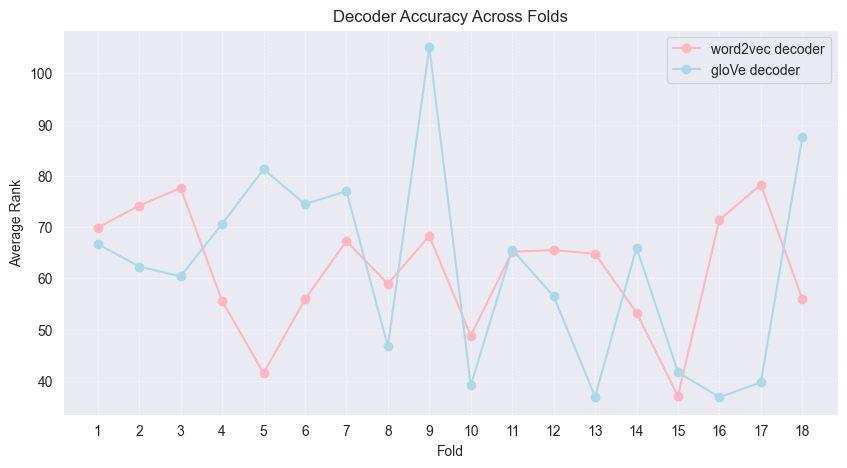

In [12]:
# Plot The Results
num_folds = 18
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_folds + 1), avg_ranks_word2vec, marker='o', label='word2vec decoder', color='lightpink')
plt.plot(range(1, num_folds + 1), avg_ranks_og, marker='o', label='gloVe decoder', color='lightblue')
plt.xlabel("Fold")
plt.ylabel("Average Rank")
plt.title("Decoder Accuracy Across Folds")
plt.xticks(range(1, num_folds + 1))
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
plt.show()

In [13]:
df_concept_ranks = pd.DataFrame(concept_ranks, columns=["Concept", "Rank"])

# Best decoded concepts (lowest rank)
print("Top 10 best-decoded concepts:")
print(df_concept_ranks.sort_values("Rank").head(10).to_string(index=False))

# Worst decoded concepts (highest rank)
print("\nBottom 10 worst-decoded concepts:")
print(df_concept_ranks.sort_values("Rank", ascending=False).head(10).to_string(index=False))


Top 10 best-decoded concepts:
Concept  Rank
     do     1
   time     1
   food     1
  great     2
  laugh     4
 stupid     5
   lady     6
   left     6
   hair     7
  money     7

Bottom 10 worst-decoded concepts:
        Concept  Rank
argumentatively   180
      cockroach   178
       applause   175
        deceive   171
       electron   168
       dissolve   164
          movie   159
       elegance   158
         usable   158
            sew   157


In [14]:
df = pd.DataFrame(concept_ranks, columns=["Concept", "Rank"])
concept_avg_ranks = df.groupby("Concept").mean()

# Count how many concepts had average rank < 90
good_concepts = concept_avg_ranks[concept_avg_ranks["Rank"] < 90]
print(f"Number of concepts with average rank < 90: {len(good_concepts)}")

# Also show overall mean rank
overall_avg_rank = concept_avg_ranks["Rank"].mean()
print(f"Overall average concept rank: {overall_avg_rank:.2f}")


Number of concepts with average rank < 90: 134
Overall average concept rank: 61.91


## Section 2

The three main analyses presented in the article share a common methodological framework, centered on learning a linear mapping from fMRI activation patterns to semantic vector representations of linguistic stimuli. All analyses employ ridge regression, use a fixed set of 5,000 voxels selected per subject, and evaluate decoding performance using rank accuracy. In Analysis 1, the authors focus on word-level decoding, training and testing the decoder on fMRI responses to 180 concrete nouns using an 18-fold cross-validation scheme. This analysis establishes a strong baseline for concept-level semantic decoding. Analysis 2 investigates the generalizability of the word-trained decoder to sentence-level stimuli. Here, the decoder is trained on the word data from Analysis 1 and tested on 384 novel sentences, represented as the average of their constituent word embeddings. Analysis 3 further probes generalization by evaluating the same decoder on a separate set of 243 sentences collected in a different imaging session.


## Section 3

In [15]:
# Second Analysis
with open("analyses 2 and 3 data/EXP2.pkl", "rb") as f:
    exp2 = pickle.load(f)

glove_vectors_second_analysis = np.loadtxt("analyses 2 and 3 data/vectors_384sentences.GV42B300.average.txt")
fmri_second_analysis = exp2['Fmridata']

In [16]:
data = pd.read_csv("analyses 2 and 3 data/neuralData_for_EXP1.csv")
data.drop(columns=['Unnamed: 0'], inplace=True)
M = learn_decoder(data, vectors)

In [17]:
predicted_vectors_second_analysis = fmri_second_analysis @ M
analysis_2_ranks = []
for i in range(len(predicted_vectors_second_analysis)):
    rank = average_rank(predicted_vectors_second_analysis[i], i, glove_vectors_second_analysis)
    analysis_2_ranks.append(rank)

mean_rank = np.mean(analysis_2_ranks)

print(f"Mean Rank for Analysis 2: {mean_rank:.2f}")


Mean Rank for Analysis 2: 156.93


In [18]:
# Third Analysis
with open("analyses 2 and 3 data/EXP3.pkl", "rb") as f:
    exp3 = pickle.load(f)
fmri_third_analysis = exp3['Fmridata']
glove_vectors_third_analysis = np.loadtxt("analyses 2 and 3 data/vectors_243sentences.GV42B300.average.txt")
predicted_vectors_third_analysis = fmri_third_analysis @ M

In [19]:
analysis_3_ranks = []
for i in range(len(predicted_vectors_third_analysis)):
    rank = average_rank(predicted_vectors_third_analysis[i], i, glove_vectors_third_analysis)
    analysis_3_ranks.append(rank)

mean_rank = np.mean(analysis_3_ranks)

print(f"Mean Rank for Analysis 3: {mean_rank:.2f}")

Mean Rank for Analysis 3: 100.74


## Section 4

In [20]:
def mean_accuracy_by_topic(rank_accuracies, sentence_topics):
    """
    Calculate the mean accuracy for each topic based on rank accuracies and sentence topics.
    """
    topic_accs = defaultdict(list)
    for acc, topic in zip(rank_accuracies, sentence_topics):
        topic_accs[topic].append(acc)
    return {topic: np.mean(accs) for topic, accs in topic_accs.items()}

In [21]:
def plot_top_bottom_topics(topic_accuracy, n=5, title="Topic Rank Accuracies"):
    """
    Plot the top and bottom n topics based on their mean rank accuracy.
    """
    sorted_topics = sorted(topic_accuracy.items(), key=lambda x: x[1], reverse=False)
    top_topics = sorted_topics[:n]
    bottom_topics = sorted_topics[-n:]
    df = pd.DataFrame(top_topics + bottom_topics, columns=["Topic", "Accuracy"])
    df["Group"] = ["Top"] * n + ["Bottom"] * n
    plt.figure(figsize=(10, 6))
    sns.barplot(data=df, x="Accuracy", y="Topic", hue="Group", dodge=False,
                palette={"Top": "#90EE90", "Bottom": "salmon"})
    plt.title(title)
    plt.xlabel("Mean Rank Accuracy")
    plt.ylabel("Topic")
    plt.legend(title="Group")
    plt.tight_layout()
    plt.show()

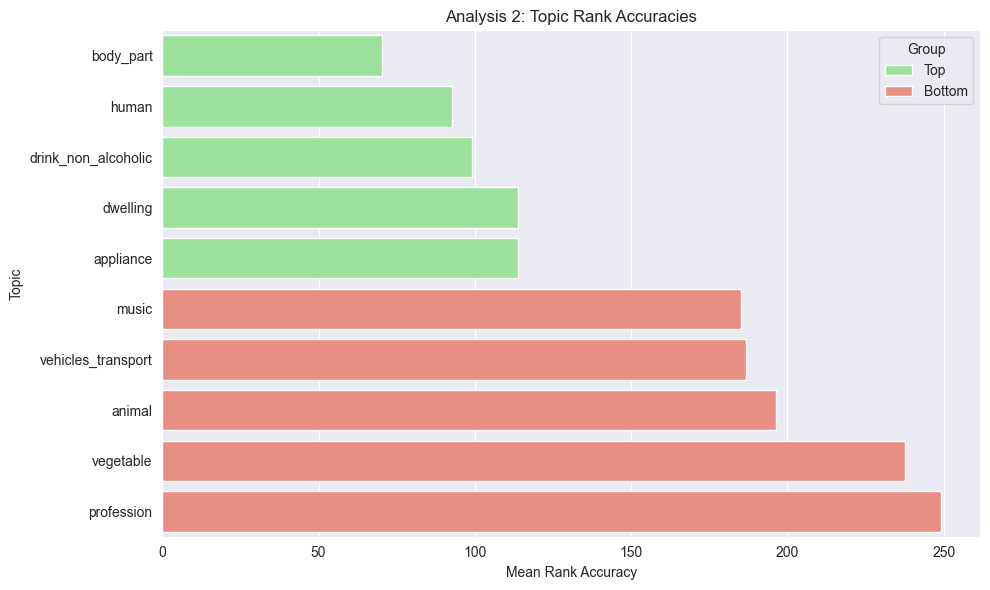

In [22]:
# Analysis 2
passage_ids = pd.Series(exp2["labelsPassageForEachSentence"].flatten()) - 1
topic_ids = pd.Series(exp2["labelsPassageCategory"].flatten()) - 1
topics = pd.Series(exp2["keyPassageCategory"][0]).str[0]
sentence_topics_2 = topics[topic_ids[passage_ids]].tolist()
acc_by_topic_2 = mean_accuracy_by_topic(analysis_2_ranks, sentence_topics_2)
plot_top_bottom_topics(acc_by_topic_2, n=5, title="Analysis 2: Topic Rank Accuracies")

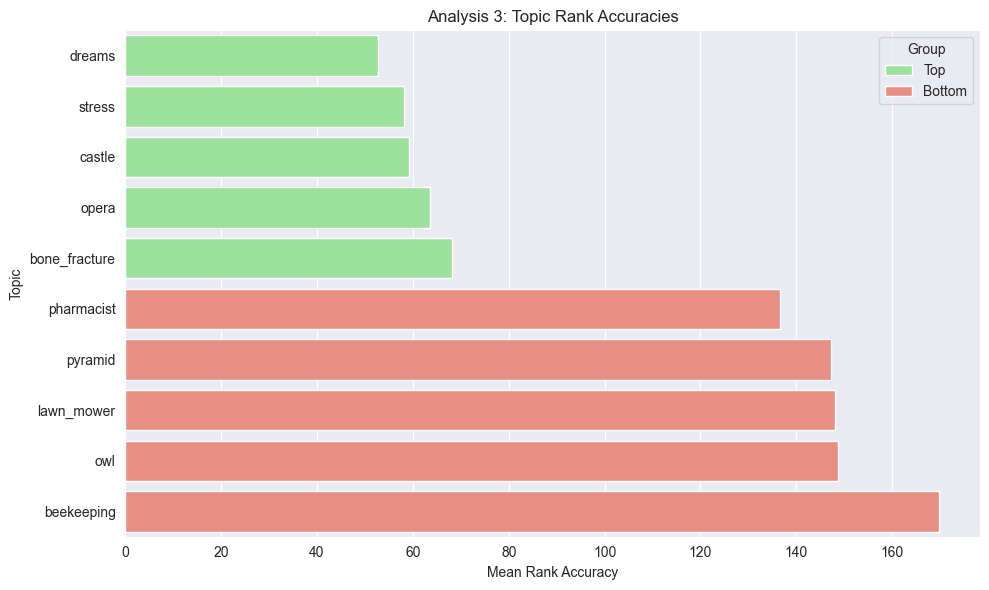

In [23]:
# Analysis 3
passage_ids = pd.Series(exp3["labelsPassageForEachSentence"].flatten()) - 1
topic_ids = pd.Series(exp3["labelsPassageCategory"].flatten()) - 1
topics = pd.Series(exp3["keyPassageCategory"][0]).str[0]
sentence_topics_3 = topics[topic_ids[passage_ids]].tolist()
acc_by_topic_3 = mean_accuracy_by_topic(analysis_3_ranks, sentence_topics_3)
plot_top_bottom_topics(acc_by_topic_3, n=5, title="Analysis 3: Topic Rank Accuracies")

# Task 2: Sentence Representations

In [24]:
#!pip install numpy pandas scikit-learn transformers tqdm gensim

In [25]:
from tqdm import tqdm
import random
import torch
from transformers import BertTokenizer, BertModel

C:\Users\orosh\OneDrive\Desktop\python projects\second_degree\cognition\final_project\pythonProject\.venv3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [26]:
# Config
RIDGE_ALPHA = 100.0
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

In [27]:
concepts = np.genfromtxt('stimuli_180concepts.txt', dtype=np.dtype('U'))

In [28]:
avg_ranks_glove, concept_ranks_glove, _ = cross_validated_decoder(
    data=fmri_second_analysis,
    vectors=glove_vectors_second_analysis,
    concepts=concepts,
)

In [29]:
# Load pretrained BERT model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased').to(DEVICE)
model.eval()

# Generate BERT sentence embeddings
bert_vectors = []
sentences = exp2['keySentences']

with torch.no_grad():
    for sentence in tqdm(sentences, desc="Extracting BERT embeddings"):
        inputs = tokenizer(sentence[0][0], return_tensors="pt", truncation=True, max_length=512).to(DEVICE)
        outputs = model(**inputs)
        cls_embedding = outputs.last_hidden_state.mean(dim=1).squeeze().numpy()
        bert_vectors.append(cls_embedding)

bert_vectors = np.vstack(bert_vectors)
print("BERT embeddings shape:", bert_vectors.shape)


Extracting BERT embeddings: 100%|██████████| 384/384 [00:26<00:00, 14.68it/s]

BERT embeddings shape: (384, 768)


In [30]:
avg_ranks_bert, concept_ranks_bert, _ = cross_validated_decoder(
    data=fmri_second_analysis,
    vectors=bert_vectors,
    concepts=concepts
)

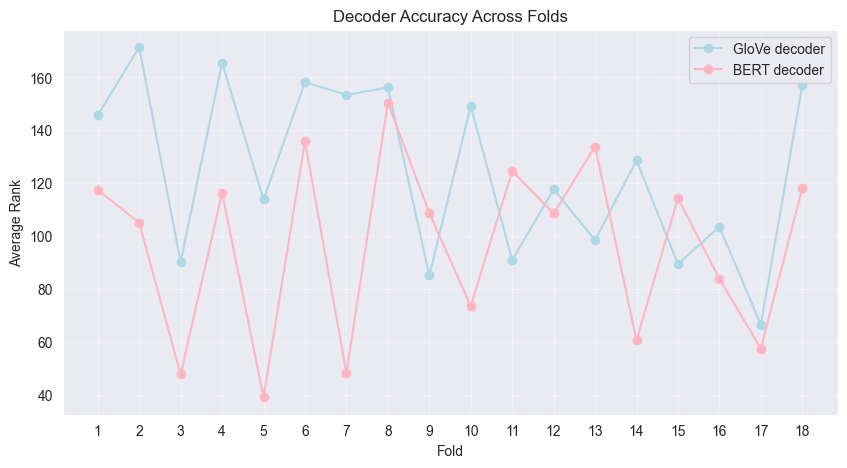

In [31]:
# Compare average rank across folds
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_folds + 1), avg_ranks_glove, marker='o', label='GloVe decoder', color='lightblue')
plt.plot(range(1, num_folds + 1), avg_ranks_bert, marker='o', label='BERT decoder', color='lightpink')
plt.xlabel("Fold")
plt.ylabel("Average Rank")
plt.title("Decoder Accuracy Across Folds")
plt.xticks(range(1, num_folds + 1))
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
plt.show()

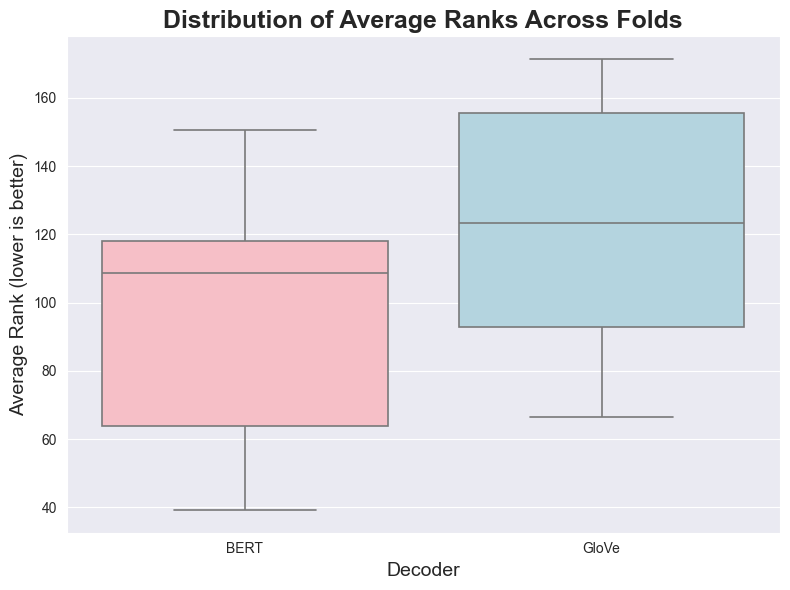

In [32]:
# Distribution plot of all folds combined
avg_ranks_bert = np.array(avg_ranks_bert)
avg_ranks_glove = np.array(avg_ranks_glove)


df = pd.DataFrame({
    "Fold": np.tile(np.arange(1, len(avg_ranks_bert)+1), 2),
    "Average Rank": np.concatenate([avg_ranks_bert, avg_ranks_glove]),
    "Decoder": ["BERT"] * len(avg_ranks_bert) + ["GloVe"] * len(avg_ranks_glove)
})
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x="Decoder", y="Average Rank", hue="Decoder", linewidth=1.2, palette={'BERT': 'lightpink', 'GloVe': 'lightblue'})
plt.title("Distribution of Average Ranks Across Folds", fontsize=18, weight="bold")
plt.xlabel("Decoder", fontsize=14)
plt.ylabel("Average Rank (lower is better)", fontsize=14)
plt.tight_layout()
plt.show()

In [33]:
def plot_best_and_worst_concepts(concept_ranks, top_n=5, title="Top and Bottom Decoded Concepts"):
    """
    Plot top-N best and bottom-N worst decoded concepts in one barplot.
    """

    df = pd.DataFrame(concept_ranks, columns=["Concept", "Rank"])
    best_df = df.sort_values("Rank").head(top_n).copy()
    best_df["Category"] = "Best"
    worst_df = df.sort_values("Rank", ascending=False).head(top_n).copy()
    worst_df["Category"] = "Worst"

    # Combine and sort so that 'Best' comes first in the y-axis (top to bottom)
    combined_df = pd.concat([best_df, worst_df], ignore_index=True)
    combined_df["SortOrder"] = combined_df["Category"].map({"Best": 0, "Worst": 1})
    combined_df = combined_df.sort_values(["SortOrder", "Rank"], ascending=[True, True])

    sns.set(style="whitegrid", font_scale=1.2)
    plt.figure(figsize=(10, 6))

    ax = sns.barplot(
        data=combined_df, x="Rank", y="Concept", hue='Category',
        palette={"Best": "green", "Worst": "red"}, edgecolor=".2", linewidth=1.2
    )

    plt.title(title, fontsize=18, weight="bold")
    plt.xlabel("Average Rank", fontsize=14)
    plt.ylabel("Concept", fontsize=14)

    # Move legend outside the plot
    plt.legend(title="Category", loc='center left', bbox_to_anchor=(1.02, 0.5), borderaxespad=0.)

    plt.tight_layout()
    plt.show()


In [34]:
len(concepts)

180

In [35]:
len(concept_ranks_glove)

180

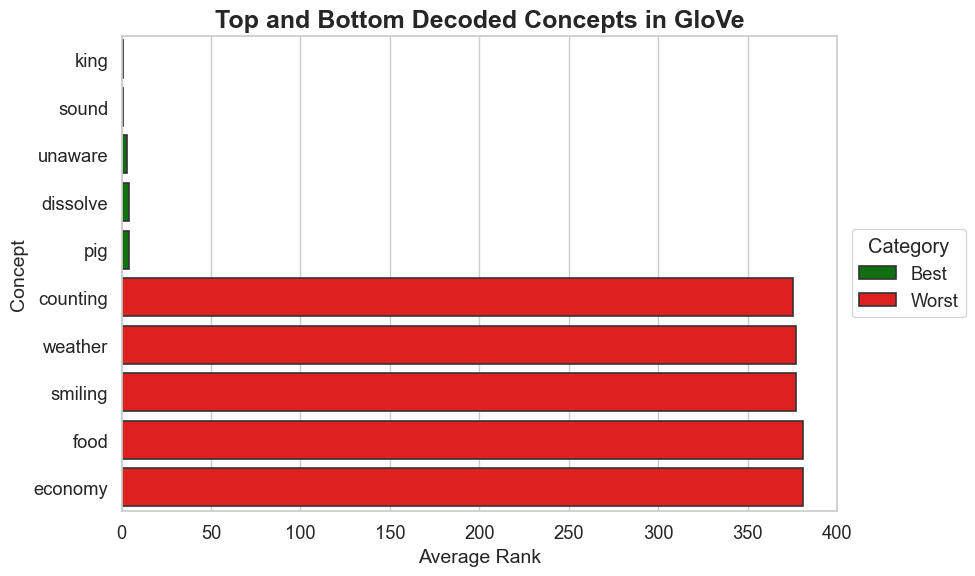

In [36]:
# Glove concepts ranks plot
plot_best_and_worst_concepts(concept_ranks_glove, top_n=5, title="Top and Bottom Decoded Concepts in GloVe")

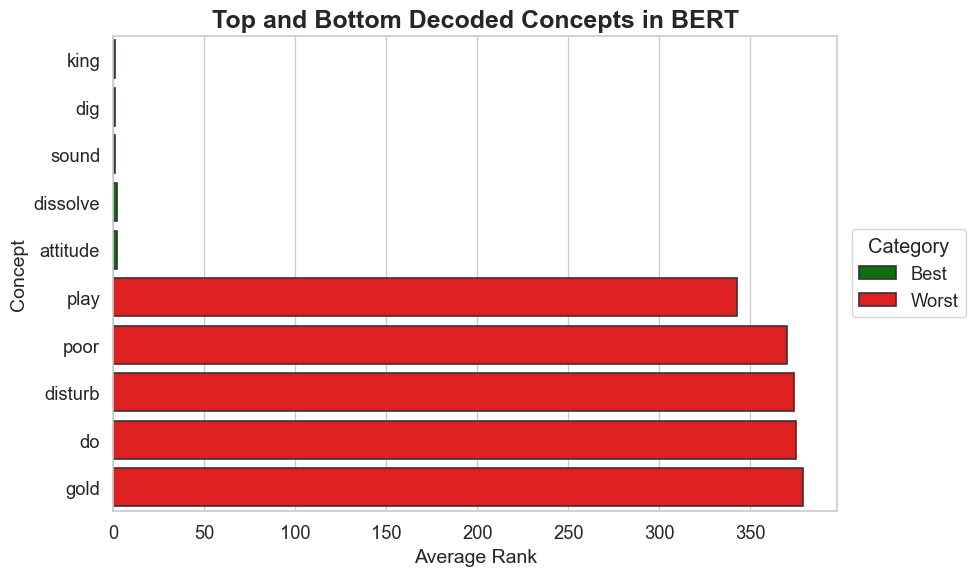

In [37]:
plot_best_and_worst_concepts(concept_ranks_bert, top_n=5, title="Top and Bottom Decoded Concepts in BERT")

# Task 3: Brain encoder model